In [50]:
import pandas as pd
from sklearn.utils import resample
from sklearn import metrics

In [51]:
train = pd.read_pickle("./data/train.pickle")
test = pd.read_pickle("./data/test.pickle")

## Upsampling

In [52]:
train_majority = train[train.returnLabel==0].reset_index(drop=True)
train_minority = train[train.returnLabel==1].reset_index(drop=True)

# Upsample minority class
target_size = train_majority.shape[0]
upsampled = resample(train_minority, replace=True, n_samples=target_size, random_state=0)

# Combine majority class with upsampled minority class
train_upsampled = pd.concat([train_majority, upsampled])

# Show new class counts
train_upsampled.returnLabel.value_counts()

1    21495
0    21495
Name: returnLabel, dtype: int64

In [53]:
X_train = train_upsampled.drop("returnLabel", axis=1)
y_train = train_upsampled["returnLabel"]
X_test = test.drop("returnLabel", axis=1)
y_test = test["returnLabel"]

In [54]:
X_train.shape

(42990, 908)

In [55]:
train_upsampled.to_pickle("./data/train_upsampled.pickle")

In [34]:
from sklearn.linear_model import LogisticRegression
logreg_up = LogisticRegression(max_iter=5000)
logreg_up.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

In [58]:
from sklearn.ensemble import GradientBoostingClassifier
gbt_up = GradientBoostingClassifier()
gbt_up.fit(X_train, y_train)

GradientBoostingClassifier()

In [36]:
test_scores = logreg_up.predict_proba(X_test)
fpr_reg_up, tpr_reg_up, _ = metrics.roc_curve(y_test, test_scores[:,1])
auc_reg_up = metrics.auc(fpr_reg_up, tpr_reg_up)

In [37]:
test_scores = gbt_up.predict_proba(X_test)
fpr_gbt_up, tpr_gbt_up, _ = metrics.roc_curve(y_test, test_scores[:,1])
auc_gbt_up = metrics.auc(fpr_gbt_up, tpr_gbt_up)

In [38]:
predictions = pd.read_csv("./data/predictions_test.csv")
fpr_reg, tpr_reg, _ = metrics.roc_curve(predictions["label"], predictions["predReg"])
auc_reg = metrics.auc(fpr_reg, tpr_reg)
fpr_gbt, tpr_gbt, _ = metrics.roc_curve(predictions["label"], predictions["predGbt"])
auc_gbt = metrics.auc(fpr_gbt, tpr_gbt)

In [39]:
print(f"AUC - normal regression:{auc_reg:.3f}")
print(f"AUC - upsampled regression:{auc_reg_up:.3f}")
print(f"AUC - normal GBT:{auc_gbt:.3f}")
print(f"AUC - upsampled GBT:{auc_gbt_up:.3f}")

AUC - normal regression:0.956
AUC - upsampled regression:0.943
AUC - normal GBT:0.935
AUC - upsampled GBT:0.948


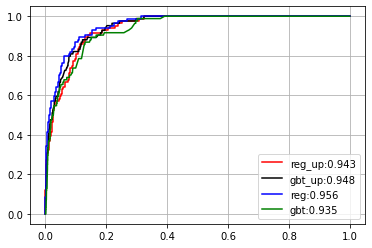

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_reg_up, tpr_reg_up, color = 'red', label=f"reg_up:{auc_reg_up:.3f}")
plt.plot(fpr_gbt_up, tpr_gbt_up, color = 'black', label=f"gbt_up:{auc_gbt_up:.3f}")
plt.plot(fpr_reg, tpr_reg, color = 'blue', label=f"reg:{auc_reg:.3f}")
plt.plot(fpr_gbt, tpr_gbt, color = 'green', label=f"gbt:{auc_gbt:.3f}")
plt.legend()
plt.grid()
plt.show()

In [41]:
# save predictions of upsampled reg model
predictions['predGbt_up'] = test_scores[:,1]
predictions.to_csv("./data/predictions_up.csv", index=False)

In [42]:
# save predictions to csv
df = pd.read_csv("./data/predictions_train.csv")
df["predGbt_up"] = logreg_up.predict_proba(train[train.columns[1:]])[:,1]
df.to_csv("./data/predictions_train_up.csv", index=False)

In [59]:
# save the model to re-use it in the next task
import joblib
joblib.dump(gbt_up, "model/gbt_upsampled.pkl")

['model/gbt_upsampled.pkl']

## Downsampling

In [43]:
target_size = train_minority.shape[0]
downsampled = resample(train_majority, n_samples=target_size, random_state=0)
train_downsampled = pd.concat([downsampled, train_minority])

# Show new class counts
train_downsampled.returnLabel.value_counts()

1    205
0    205
Name: returnLabel, dtype: int64

In [44]:
X_train = train_downsampled.drop("returnLabel", axis=1)
y_train = train_downsampled["returnLabel"]

In [45]:
logreg_down = LogisticRegression(max_iter=5000)
logreg_down.fit(X_train, y_train)
gbt_down = GradientBoostingClassifier()
gbt_down.fit(X_train, y_train)

GradientBoostingClassifier()

In [46]:
test_scores = logreg_down.predict_proba(X_test)
fpr_reg_down, tpr_reg_down, _ = metrics.roc_curve(y_test, test_scores[:,1])
auc_reg_down = metrics.auc(fpr_reg_down, tpr_reg_down)
test_scores = gbt_down.predict_proba(X_test)
fpr_gbt_down, tpr_gbt_down, _ = metrics.roc_curve(y_test, test_scores[:,1])
auc_gbt_down = metrics.auc(fpr_gbt_down, tpr_gbt_down)

In [47]:
print(f"AUC - normal regression:{auc_reg:.3f}")
print(f"AUC - downsampled regression:{auc_reg_down:.3f}")
print(f"AUC - normal GBT:{auc_gbt:.3f}")
print(f"AUC - downsampled GBT:{auc_gbt_down:.3f}")

AUC - normal regression:0.956
AUC - downsampled regression:0.954
AUC - normal GBT:0.935
AUC - downsampled GBT:0.942


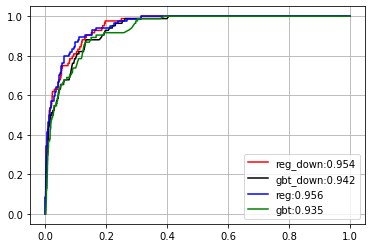

In [48]:
plt.figure()
plt.plot(fpr_reg_down, tpr_reg_down, color='red', label=f"reg_down:{auc_reg_down:.3f}")
plt.plot(fpr_gbt_down, tpr_gbt_down, color='black', label=f"gbt_down:{auc_gbt_down:.3f}")
plt.plot(fpr_reg, tpr_reg, color='blue', label=f"reg:{auc_reg:.3f}")
plt.plot(fpr_gbt, tpr_gbt, color='green', label=f"gbt:{auc_gbt:.3f}")
plt.legend()
plt.grid()
plt.show()

### SMOTE algorithm

In [49]:
import imblearn
X_train = train.drop("returnLabel", axis=1)
y_train = train["returnLabel"]

sm = imblearn.over_sampling.SMOTE(random_state=0)
X_res, y_res = sm.fit_resample(X_train, y_train)

logreg_sm = LogisticRegression(max_iter=5000)
logreg_sm.fit(X_res, y_res)

KeyboardInterrupt: 

In [ ]:
test_scores = logreg_sm.predict_proba(X_test)
fpr_reg_sm, tpr_reg_sm, _ = metrics.roc_curve(y_test, test_scores[:,1])
auc_reg_sm = metrics.auc(fpr_reg_sm, tpr_reg_sm)

In [ ]:
print(f"AUC - normal regression:{auc_reg:.3f}")
print(f"AUC - SMOTE + regression:{auc_reg_sm:.3f}")

In [ ]:
plt.figure()
plt.plot(fpr_reg, tpr_reg, color='blue', label=f"reg:{auc_reg:.3f}")
plt.plot(fpr_reg_sm, tpr_reg_sm, color='red', label=f"reg_sm:{auc_reg_sm:.3f}")
plt.legend()
plt.grid()
plt.show()